In [1]:
import os
import numpy as np
import pandas as pd
import core.pre_processing_utils
from matplotlib.image import imread
from tensorflow.keras.metrics import AUC as auc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_dir = 'chest_xray'

In [3]:
test_path = data_dir + '/test'
train_path = data_dir + '/train'
val_path = data_dir + '/val'

In [4]:
image_shape = (300, 300, 3)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
image_gen = ImageDataGenerator(fill_mode='nearest')

In [7]:
image_gen.flow_from_directory(train_path)

Found 5216 images belonging to 2 classes.


In [8]:
image_gen.flow_from_directory(test_path)

Found 6240 images belonging to 2 classes.


In [9]:
image_gen.flow_from_directory(val_path)

Found 16 images belonging to 2 classes.


<h2>Building a Model</h2>

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, Layer, concatenate, GlobalAveragePooling2D,Activation, Softmax
from tensorflow.keras.metrics import Accuracy, AUC

In [11]:
class fire_module(Layer):
    
    def __init__(self, squeeze_size=16, expand_size=64):
        super(fire_module, self).__init__()
        self.squeeze = Conv2D(filters=squeeze_size, kernel_size=(1,1), padding='valid', \
                              activation='relu', name="sq1x1")
        self.exp1_1 = Conv2D(filters=expand_size, kernel_size=(1,1), padding='valid', \
                             activation='relu', name="exp1x1")
        self.exp3_3 = Conv2D(filters=expand_size, kernel_size=(3,3), padding='same', \
                             activation='relu', name="exp3x3")
    
    def call(self, input):
        squeezed_value = self.squeeze(input)
        exp1_1_value = self.exp1_1(squeezed_value)
        exp3_3_value = self.exp3_3(squeezed_value)
        return concatenate([exp1_1_value, exp3_3_value], axis=-1, name='concat')
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'squeeze': self.squeeze,
            'exp1_1': self.exp1_1,
            'exp3_3': self.exp3_3
        })
        return config

In [12]:
loss_param = 'binary_crossentropy'
optimizer_param = 'adam'
stop_monitor = 'val_auc'
stop_mode = 'max'
stop_patience = 2
batch_size = 64

In [13]:
model = Sequential()
model.add(Conv2D(filters=8, kernel_size=(3,3), input_shape=image_shape, activation='relu'))

model.add(fire_module(6,8))
model.add(MaxPool2D(pool_size=(3,3)))

model.add(fire_module(12,16))
model.add(MaxPool2D(pool_size=(3,3)))

model.add(fire_module(18,24))
model.add(MaxPool2D(pool_size=(3,3)))

model.add(Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid'))
model.add(GlobalAveragePooling2D())

model.compile(loss=loss_param, optimizer=optimizer_param,
             metrics=[AUC()])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 8)       224       
_________________________________________________________________
fire_module (fire_module)    (None, 298, 298, 16)      550       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 16)        0         
_________________________________________________________________
fire_module_1 (fire_module)  (None, 99, 99, 32)        2156      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 32)        0         
_________________________________________________________________
fire_module_2 (fire_module)  (None, 33, 33, 48)        4962      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 48)        0

<h2>Regularization</h2>

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import normalize

In [16]:
early_stop = EarlyStopping(monitor=stop_monitor, mode=stop_mode, patience=stop_patience)

In [17]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size = image_shape[:2],
                                               batch_size = batch_size,
                                               class_mode = 'binary')

Found 5216 images belonging to 2 classes.


In [18]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               batch_size = batch_size,
                                               class_mode='binary',
                                               shuffle=False) # Don't want to shuffle test data and lose labels

Found 6240 images belonging to 2 classes.


In [19]:
test_image_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

<h2>Running the Model</h2>

In [20]:
# Running without early stop for now - not enough examples for 'val_loss'?
results = model.fit(train_image_gen, epochs=20,
                             validation_data=test_image_gen,
                    callbacks=[early_stop]
                   )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 82 steps, validate for 98 steps
Epoch 1/20
56/82 [===================>..........] - ETA: 1:29 - loss: 0.5342 - auc: 0.6935WARNING:tensorflow:Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: loss,auc


KeyboardInterrupt: 

<h2>Recording</h2>

In [ ]:
import os

losses = model.history.history
losses['loss'] = np.asarray(losses['loss'])
losses['val_loss'] = np.asarray(losses['val_loss'])
final_number_of_epochs = len(losses['loss'])
min_loss = losses['loss'].min()
mean_loss = losses['loss'].mean()
final_loss = losses['loss'][-1]
min_val_loss = losses['val_loss'].min()
mean_val_loss = losses['val_loss'].mean()
final_val_loss = losses['val_loss'][-1]

def get_model_summary():
    output = []
    model.summary(print_fn=lambda line: output.append(line))
    return str(output).strip('[]')

summary = get_model_summary()

record = {
    'Epochs': final_number_of_epochs,
    'Batch_Size': batch_size,
    'Loss_Func': loss_param,
    'Optimizer': optimizer_param,
    'Early_Stop_Monitor': stop_monitor,
    'Early_Stop_Patience': stop_patience,
    'Min_Loss': min_loss,
    'Mean_Loss': mean_loss,
    'Final_Loss': final_loss,
    'Min_Val_Loss': min_val_loss,
    'Mean_Val_Loss': mean_val_loss,
    'Final_Val_Loss': final_val_loss,
    'Model': summary
}

new_data = pd.DataFrame(record, index=[0])

if os.path.exists('results.csv'):
    df_records = pd.read_csv('results.csv')
    df_records = df_records.append(new_data)
else:
    df_records = pd.DataFrame(new_data)
    
df_records.to_csv('results.csv', float_format='%g')

In [22]:
metrics = pd.DataFrame(model.history.history)

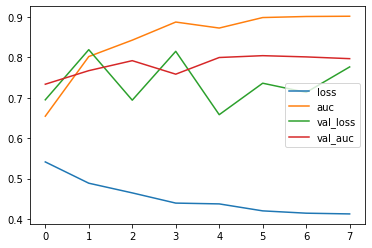

In [23]:
metrics.plot()

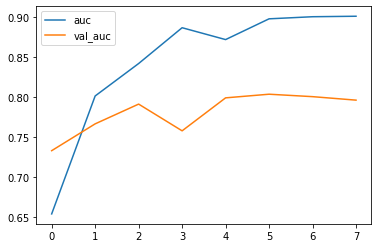

In [24]:
metrics[['auc', 'val_auc']].plot()

<p>We see that the model is overfitting significantly.</p>

In [41]:
model.save('image_classifier_auc.h5')